In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img,ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Model,Sequential
from keras.layers import GlobalAveragePooling2D,Dropout,Dense,Flatten,BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
data_dir='/content/drive/MyDrive/Brain_Tumer_Detection/'
no_tumer_dir='/content/drive/MyDrive/Brain_Tumer_Detection/no/'
yes_tumer_dir='/content/drive/MyDrive/Brain_Tumer_Detection/yes/'

In [3]:
dir_list=[no_tumer_dir,yes_tumer_dir]
classes=['No','Yes']
filepaths=[]
labels=[]
for dir,label in zip(dir_list,classes):
  filelist=os.listdir(dir)
  for file in filelist:
    filepath=os.path.join(dir,file)
    filepaths.append(filepath)
    labels.append(label)
print('files:',len(filepaths),'labels:',len(labels))

files: 253 labels: 253


In [4]:
df=pd.DataFrame({'filepaths':filepaths,'labels':labels})
df.head()

,filepaths,labels
0,/content/drive/MyDrive/Brain_Tumer_Detection/n...,No
1,/content/drive/MyDrive/Brain_Tumer_Detection/n...,No
2,/content/drive/MyDrive/Brain_Tumer_Detection/n...,No
3,/content/drive/MyDrive/Brain_Tumer_Detection/n...,No
4,/content/drive/MyDrive/Brain_Tumer_Detection/n...,No


In [5]:
df.shape

(253, 2)

In [6]:
df.filepaths[250]

'/content/drive/MyDrive/Brain_Tumer_Detection/yes/Y92.jpg'

In [7]:
df.labels[250]

'Yes'

In [8]:
df.labels.value_counts()

Yes    155
No      98
Name: labels, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


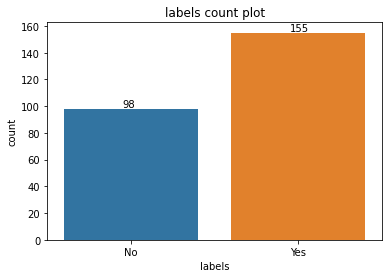

In [9]:
ax=sns.countplot(df.labels)
for p in ax.patches:
  text=p.get_height()
  x=p.get_x()+p.get_width()/2 - 0.05
  y=p.get_height()+1
  ax.text(x,y,text)
plt.title('labels count plot')
plt.show()

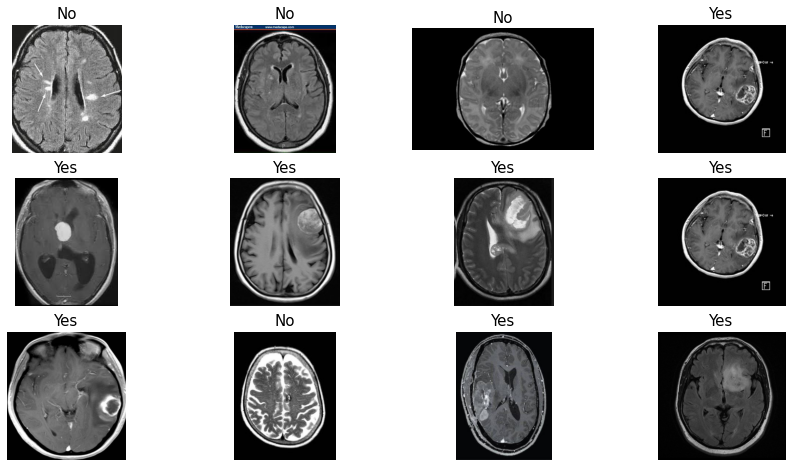

In [10]:
plt.figure(figsize=(15,8))
for i in range(12):
  random=np.random.randint(1,len(df))
  plt.subplot(3,4,i+1)
  plt.imshow(load_img(df.loc[random,'filepaths']))
  plt.title(df.loc[random,'labels'],size=15)
  plt.axis('off')
plt.show()

In [11]:
train_val, test = train_test_split(df,train_size=0.9,random_state=10)
train, val = train_test_split(train_val,train_size=0.9,random_state=10)
print(f"train set shape: {train.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {val.shape}")

train set shape: (204, 2)
test set shape: (26, 2)
validation set shape: (23, 2)


In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range = 0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_gen=train_datagen.flow_from_dataframe(dataframe=train,
                                            x_col='filepaths',
                                            y_col='labels',
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='binary',
                                            shuffle=True)
val_gen=train_datagen.flow_from_dataframe(dataframe=val,
                                          x_col='filepaths',
                                          y_col='labels',
                                          target_size=(224,224),
                                          batch_size=16,
                                          class_mode='binary',
                                          shuffle=True)
test_gen=test_datagen.flow_from_dataframe(dataframe=test,
                                          x_col='filepaths',
                                          y_col='labels',
                                          target_size=(224,224),
                                          batch_size=16,
                                          class_mode='binary',
                                          shuffle=False)

Found 204 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.


In [14]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

MODEL WITH VGG16 AS BASE MODEL

In [15]:
#https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
vgg_16 = VGG16(include_top=False,
            weights='imagenet',
            input_shape=(224,224,3))
vgg_16.trainable = False
model = Sequential()
model.add(vgg_16)
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2,activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 batch_normalization (BatchN  (None, 4096)             1

In [17]:
optimizer = Adam(learning_rate=0.001)

In [18]:
loss = SparseCategoricalCrossentropy(from_logits=False)

In [19]:
mcp = ModelCheckpoint('/content/drive/MyDrive/Brain_Tumer_Detection/VGG_16_1.h5',
                      monitor='val_accuracy',verbose=1, save_best_only=True,mode='auto',save_weights_only=False)
es = EarlyStopping(monitor='val_accuracy',patience=6, verbose=1)
cb=[mcp,es]

In [20]:
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [21]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
history=model.fit(train_gen,epochs=30,validation_data=val_gen, callbacks=cb)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.7714 - accuracy: 0.7206
Epoch 1: val_accuracy improved from -inf to 0.39130, saving model to /content/drive/MyDrive/Brain_Tumer_Detection/VGG_16_1.h5
13/13 [==============================] - 32s 2s/step - loss: 0.7714 - accuracy: 0.7206 - val_loss: 8.3673 - val_accuracy: 0.3913
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.6961
Epoch 2: val_accuracy did not improve from 0.39130
13/13 [==============================] - 4s 288ms/step - loss: 0.9098 - accuracy: 0.6961 - val_loss: 5.3011 - val_accuracy: 0.3913
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7549
Epoch 3: val_accuracy improved from 0.39130 to 0.47826, saving model to /content/drive/MyDrive/Brain_Tumer_Detection/VGG_16_1.h5
13/13 [==============================] - 10s 833ms/step - loss: 0.6586 - accuracy: 0.7549 - val_loss: 2.9211 - val_accuracy: 0.4783
Epoch 4/30
13/13 [==

In [23]:
model.load_weights('/content/drive/MyDrive/Brain_Tumer_Detection/VGG_16_1.h5')
model.evaluate(test_gen)

2/2 [==============================] - 2s 1s/step - loss: 0.3408 - accuracy: 0.9231


[0.3408240079879761, 0.9230769276618958]

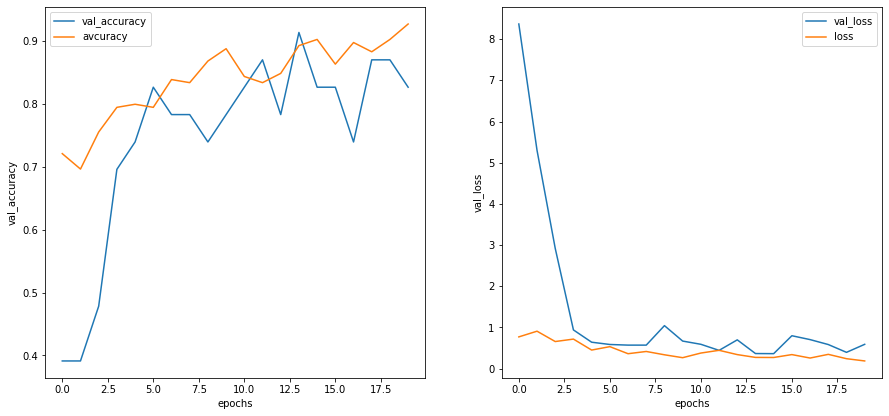

In [25]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2, 1)
sns.lineplot(data = history.history, x = range(20), y = 'val_accuracy',label='val_accuracy')
sns.lineplot(data = history.history, x = range(20), y = 'accuracy',label='avcuracy')
plt.xlabel('epochs')
plt.legend()

plt.subplot(2,2, 2)
sns.lineplot(data = history.history, x = range(20), y = 'val_loss', label='val_loss')
sns.lineplot(data = history.history, x = range(20), y = 'loss',label='loss')
plt.xlabel('epochs')
plt.legend()

MODEL WITH InceptionResNetV2 AS BASE MODEL

In [26]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet', input_shape=(200,200,3))
#https://keras.io/api/applications/inceptionresnetv2/

In [27]:
model1 = Sequential()
model1.add(base_model)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(4096, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(4096, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(Dense(2, activation = 'sigmoid'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 4096)              6295552   
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_3 (Dropout)         (None, 4096)             

In [28]:
optimizer1 = Adam(learning_rate=0.001)

In [29]:
loss1 = SparseCategoricalCrossentropy(from_logits=False)

In [34]:
mcp1 = ModelCheckpoint('/content/drive/MyDrive/Brain_Tumer_Detection/InceptionResNetV2_1.h5',
                      monitor='val_accuracy',verbose=1, save_best_only=True,mode='auto',save_weights_only=False)
es1 = EarlyStopping(monitor='val_accuracy',patience=6, verbose=1)
cb1=[mcp1,es1]

In [35]:
model1.compile(optimizer=optimizer1,loss=loss1,metrics=['accuracy'])

In [36]:
history1 = model1.fit(train_gen, validation_data = val_gen, epochs = 40, callbacks = cb1, verbose = 1)

Epoch 1/40
13/13 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9657
Epoch 1: val_accuracy improved from -inf to 0.69565, saving model to /content/drive/MyDrive/Brain_Tumer_Detection/InceptionResNetV2_1.h5
13/13 [==============================] - 37s 2s/step - loss: 0.1381 - accuracy: 0.9657 - val_loss: 0.4189 - val_accuracy: 0.6957
Epoch 2/40
13/13 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9902
Epoch 2: val_accuracy improved from 0.69565 to 0.73913, saving model to /content/drive/MyDrive/Brain_Tumer_Detection/InceptionResNetV2_1.h5
13/13 [==============================] - 12s 934ms/step - loss: 0.0456 - accuracy: 0.9902 - val_loss: 0.9207 - val_accuracy: 0.7391
Epoch 3/40
13/13 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9657
Epoch 3: val_accuracy improved from 0.73913 to 0.86957, saving model to /content/drive/MyDrive/Brain_Tumer_Detection/InceptionResNetV2_1.h5
13/13 [==============================] -

In [37]:
model1.load_weights('/content/drive/MyDrive/Brain_Tumer_Detection/InceptionResNetV2_1.h5')
model1.evaluate(test_gen)

2/2 [==============================] - 1s 869ms/step - loss: 0.3498 - accuracy: 0.9231


[0.34975379705429077, 0.9230769276618958]

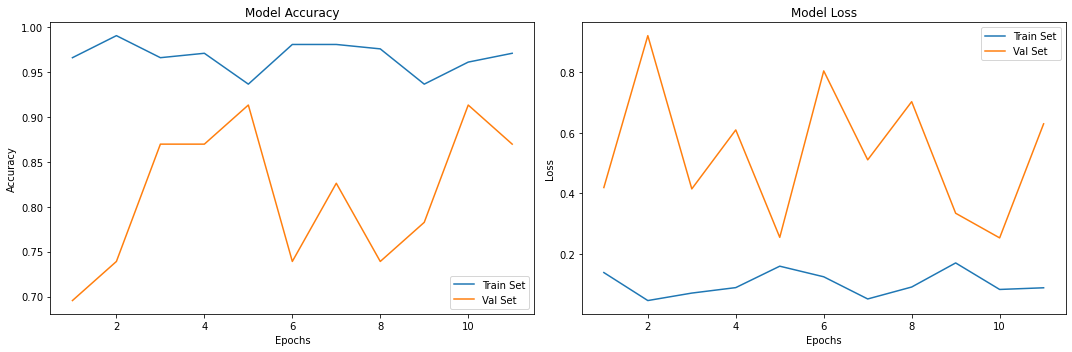

In [38]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
los = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(1, len(history1.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, los, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()